File Download

In [ ]:
!wget https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/uberday.csv

--2021-08-19 07:50:49--  https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/uberday.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1376 (1.3K) [text/plain]
Saving to: ‘uberday.csv’

uberday.csv         100%[===================>]   1.34K  --.-KB/s    in 0s      

2021-08-19 07:50:49 (51.9 MB/s) - ‘uberday.csv’ saved [1376/1376]



Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

Data Plot

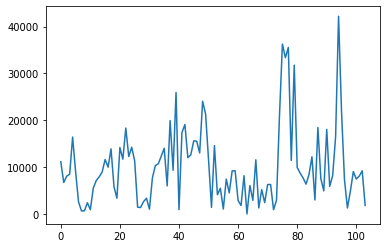

In [ ]:
training_set = pd.read_csv('uberday.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Uber Daily Ridership Data (104/01-06)')
plt.show()

Dataloading

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

Training

In [ ]:
num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.36420
Epoch: 10, loss: 0.16036
Epoch: 20, loss: 0.04503
Epoch: 30, loss: 0.01975
Epoch: 40, loss: 0.02356
Epoch: 50, loss: 0.01873
Epoch: 60, loss: 0.01924
Epoch: 70, loss: 0.01866
Epoch: 80, loss: 0.01856
Epoch: 90, loss: 0.01842
Epoch: 100, loss: 0.01832
Epoch: 110, loss: 0.01822
Epoch: 120, loss: 0.01813
Epoch: 130, loss: 0.01805
Epoch: 140, loss: 0.01797
Epoch: 150, loss: 0.01789
Epoch: 160, loss: 0.01783
Epoch: 170, loss: 0.01777
Epoch: 180, loss: 0.01771
Epoch: 190, loss: 0.01767


Testing Data

99
99
data-mse = 0.032574967
data-rmse = 0.18048537


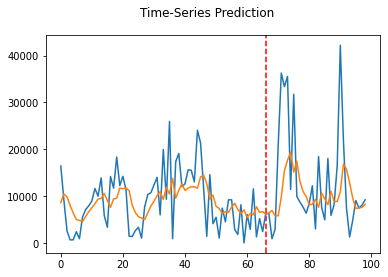

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

print(data_predict.size)
print(dataY_plot.size)
data_mse = mean_squared_error(data_predict, dataY_plot, squared=True)
data_rmse = mean_squared_error(data_predict, dataY_plot, squared=False)

print("data-mse =", data_mse)
print("data-rmse =", data_rmse)

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()